## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1')
df.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease


## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [3]:
# assign X and y
X = df[['age', 'chol']]
y = df['diagnosis']

# standardize X and create new columns
df["age_std"] = (df["age"] - df["age"].mean()) / df["age"].std()
df["chol_std"] = (df["chol"] - df["chol"].mean()) / df["chol"].std()

In [4]:
# pipeline: logistic
logistic_pipeline = Pipeline(
  [("standardize", StandardScaler()),
  ("logistic", LogisticRegression())]
)

# fit: logistic
logistic_fitted = logistic_pipeline.fit(X, y)

In [5]:
# get coefficients and intercept
logistic_age_coef = logistic_fitted.named_steps['logistic'].coef_[0][0]
logistic_chol_coef = logistic_fitted.named_steps['logistic'].coef_[0][1]
logistic_intercept = logistic_fitted.named_steps['logistic'].intercept_
logistic_age_coef, logistic_chol_coef, logistic_intercept

(np.float64(0.42746115369956383),
 np.float64(0.09597542617159378),
 array([-0.27025982]))

In [6]:
# get y predictions, probabilities, and scores and create new columns
logistic_preds = logistic_pipeline.predict(X)
logistic_probs = logistic_pipeline.predict_proba(X)[:, 1]
logistic_scores = logistic_intercept + logistic_age_coef * df['age_std'] + logistic_chol_coef * df['chol_std']
df["logistic_preds"] = logistic_preds
df["logistic_probs"] = logistic_probs
df["logistic_scores"] = logistic_scores

In [7]:
df.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis,age_std,chol_std,logistic_preds,logistic_probs,logistic_scores
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease,0.661295,-0.345593,Disease,0.494966,-0.020750
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease,0.661295,1.309270,No Disease,0.534714,0.138076
2,Miles Wolf,62,0,3,130,263,1,97,No Disease,0.875090,0.274981,No Disease,0.532749,0.130199
3,Mikaila Block,43,1,1,115,303,1,181,Disease,-1.155957,1.027191,Disease,0.339219,-0.665801
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease,1.302679,1.008386,No Disease,0.595072,0.383365


In [25]:
# means and stds: age + chol
age_mean = df['age'].mean()
age_std = df['age'].std()
chol_mean = df['chol'].mean()
chol_std = df['chol'].std()

# standardize age = 55
age_55_std = (55 - age_mean) / age_std

In [21]:
# 55-year-old: logistic
logistic_chol_std_cutoff = (-logistic_intercept - logistic_age_coef * age_55_std) / logistic_chol_coef
cutoff_logistic = logistic_chol_std_cutoff * chol_std + chol_mean
print(f"Cholesterol Level for 55-Year-Old: {cutoff_logistic[0]:.4f}")

Cholesterol Level for 55-Year-Old: 368.0853


In [24]:
# 55-year-old: logistic (90% probability)
prob_90 = np.log(9)
logistic_chol_std_cutoff_90 = (prob_90 - logistic_intercept - logistic_age_coef * age_55_std) / logistic_chol_coef
cutoff_logistic_90 = logistic_chol_std_cutoff_90 * chol_std + chol_mean
print(f"Cholesterol Level for 55-Year-Old at 90% Probability: {cutoff_logistic_90[0]:.4f}")

Cholesterol Level for 55-Year-Old at 90% Probability: 1585.4905


## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [8]:
# pipeline: lda
lda_pipeline = Pipeline(
  [("standardize", StandardScaler()),
  ("lda", LinearDiscriminantAnalysis())]
)

# fit: lda
lda_fitted = lda_pipeline.fit(X, y)

In [9]:
# get coefficients and intercept
lda_age_coef = lda_fitted.named_steps['lda'].coef_[0][0]
lda_chol_coef = lda_fitted.named_steps['lda'].coef_[0][1]
lda_intercept = lda_fitted.named_steps['lda'].intercept_
lda_age_coef, lda_chol_coef, lda_intercept

(np.float64(0.4344658185163842),
 np.float64(0.09493491278066943),
 array([-0.26973565]))

In [10]:
lda_preds = lda_pipeline.predict(X)
lda_probs = lda_pipeline.predict_proba(X)[:, 1]
lda_scores = lda_intercept + lda_age_coef * df['age_std'] + lda_chol_coef * df['chol_std']
df["lda_preds"] = lda_preds
df["lda_probs"] = lda_probs
df["lda_scores"] = lda_scores

In [11]:
df.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis,age_std,chol_std,logistic_preds,logistic_probs,logistic_scores,lda_preds,lda_probs,lda_scores
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease,0.661295,-0.345593,Disease,0.494966,-0.020750,Disease,0.496348,-0.015234
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease,0.661295,1.309270,No Disease,0.534714,0.138076,No Disease,0.535660,0.141870
2,Miles Wolf,62,0,3,130,263,1,97,No Disease,0.875090,0.274981,No Disease,0.532749,0.130199,No Disease,0.534337,0.136566
3,Mikaila Block,43,1,1,115,303,1,181,Disease,-1.155957,1.027191,Disease,0.339219,-0.665801,Disease,0.337280,-0.674443
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease,1.302679,1.008386,No Disease,0.595072,0.383365,No Disease,0.597147,0.391965


In [26]:
# 55-year-old: lda
lda_chol_std_cutoff = (-lda_intercept - lda_age_coef * age_55_std) / lda_chol_coef
cutoff_lda = lda_chol_std_cutoff* chol_std + chol_mean
print(f"Cholesterol Level for 55-Year-Old: {cutoff_lda[0]:.4f}")

Cholesterol Level for 55-Year-Old: 368.6061


## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [12]:
# pipeline: svc
svc_pipeline = Pipeline(
  [("standardize", StandardScaler()),
  ("svc", SVC(kernel = 'linear', probability = True))]
)

# tuning: svc
param_grid = {'svc__C': [0.01, 0.1, 1, 10, 100]}
svc_pipeline_grid = GridSearchCV(svc_pipeline, param_grid, cv = 5)

In [13]:
# fit best: svc
svc_fitted = svc_pipeline_grid.fit(X, y)
svc_best = svc_pipeline_grid.best_estimator_
svc_pipeline = svc_best.named_steps["svc"]
svc_pipeline

SVC(C=10, kernel='linear', probability=True)

In [14]:
svc_age_coef  = svc_pipeline.coef_[0][0]
svc_chol_coef = svc_pipeline.coef_[0][1]
svc_intercept = svc_pipeline.intercept_[0]
svc_age_coef, svc_chol_coef, svc_intercept

(np.float64(0.6009556681731714),
 np.float64(0.19360163718551782),
 np.float64(-0.31134523984506396))

In [15]:
svc_preds = svc_best.predict(X)
svc_probs = svc_best.predict_proba(X)[:, 1]
svc_scores = svc_intercept + svc_age_coef * df['age_std'] + svc_chol_coef * df['chol_std']
df["svc_preds"] = svc_preds
df["svc_probs"] = svc_probs
df["svc_scores"] = svc_scores

In [16]:
df.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis,age_std,chol_std,logistic_preds,logistic_probs,logistic_scores,lda_preds,lda_probs,lda_scores,svc_preds,svc_probs,svc_scores
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease,0.661295,-0.345593,Disease,0.494966,-0.020750,Disease,0.496348,-0.015234,No Disease,0.461731,0.019157
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease,0.661295,1.309270,No Disease,0.534714,0.138076,No Disease,0.535660,0.141870,No Disease,0.484541,0.339541
2,Miles Wolf,62,0,3,130,263,1,97,No Disease,0.875090,0.274981,No Disease,0.532749,0.130199,No Disease,0.534337,0.136566,No Disease,0.479421,0.267782
3,Mikaila Block,43,1,1,115,303,1,181,Disease,-1.155957,1.027191,Disease,0.339219,-0.665801,Disease,0.337280,-0.674443,Disease,0.404315,-0.807158
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease,1.302679,1.008386,No Disease,0.595072,0.383365,No Disease,0.597147,0.391965,No Disease,0.507917,0.666732


In [28]:
# 55-year-old: svc
svc_chol_std_cutoff = (-svc_intercept - svc_age_coef * age_55_std) / svc_chol_coef
cutoff_svc = svc_chol_std_cutoff * chol_std + chol_mean
print(f"Cholesterol Level for 55-Year-Old: {cutoff_svc:.4f}")

Cholesterol Level for 55-Year-Old: 312.9630


## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

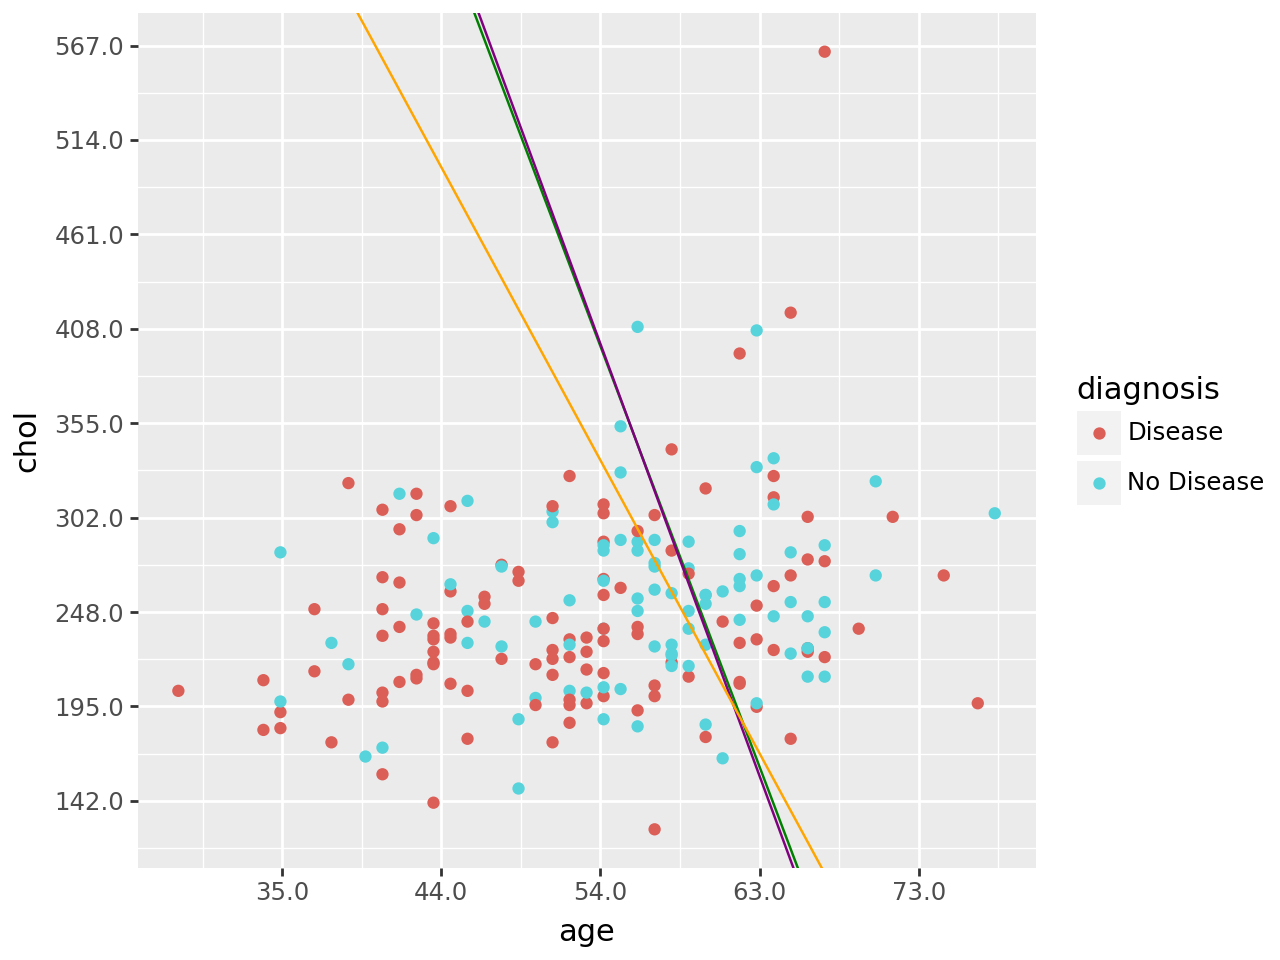

In [17]:
(ggplot(df, aes(x = 'age_std', y = 'chol_std', color = 'diagnosis'))
+ geom_point()
+ geom_abline(intercept = - logistic_intercept / logistic_chol_coef, slope = - logistic_age_coef / logistic_chol_coef, color = "green")
+ geom_abline(intercept = - lda_intercept / lda_chol_coef, slope = - lda_age_coef / lda_chol_coef, color = "purple")
+ geom_abline(intercept = - svc_intercept / svc_chol_coef, slope = - svc_age_coef / svc_chol_coef, color = "orange")
+ scale_x_continuous(breaks = np.arange(-2, 3), labels = np.round(df['age'].mean() + df['age'].std() * np.arange(-2, 3), 0))
+ scale_y_continuous(breaks = np.arange(-2, 7), labels = np.round(df['chol'].mean() + df['chol'].std() * np.arange(-2, 7), 0))
+ labs(x = 'age', y = 'chol')
)